# Benchmarking cloud generation functions

---------------------

## Using cloudmask from random Landsat images

Rather than generating artificial clouds using, say, Perlin or simplex noise, we can just use the cloud masks that come with Landsat images (any Landsat image, but obviously not an image that is part of our dataset). Using cloud cover of 20-30% right now. Not sure if there is any downside to doing this versus Perlin/Simplex noise, but couldn't figure out a way to generate cloud cover server side in GEE.

Another important point is that the cloud cover is really more for aesthetic purposes, at least until we use the classifer to predict all cloud-covered pixels. To speed things up, we could just take a random subset of the sampled points as our "cloud pixels" for testing. But then again, we ultimately want to have a figure of red/green, incorrect/correct predictions over cloud areas, which we would need artificial clouds for.

All of these methods for generating artificial cloud cover assume that cloud presence is equally probable in all pixels of an image, which isn't necessarily true if we are dealing with mountains /cloud shadow areas, large water bodies, etc. Doesn't seem too important at this point though. 

---------------------

### Understanding the parameters for noise generation
http://libnoise.sourceforge.net/tutorials/tutorial4.html

https://flafla2.github.io/2014/08/09/perlinnoise.html

## 2-dimensional Perlin noise generation
Benefit of generating native cloud cover is that we can control the % cloud cover and create a f(cloud_cover)=model accuracy relationship when testing our flood prediction models.

This Perlin noise script is from https://github.com/ruslangrimov/perlin-noise-python-numpy

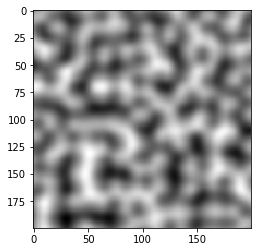

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product, count

from matplotlib.colors import LinearSegmentedColormap


def generate_unit_vectors(n):
    'Generates matrix NxN of unit length vectors'
    phi = np.random.uniform(0, 2*np.pi, (n, n))
    v = np.stack((np.cos(phi), np.sin(phi)), axis=-1)
    return v


# quintic interpolation
def qz(t):
    return t * t * t * (t * (t * 6 - 15) + 10)


# cubic interpolation
def cz(t):
    return -2 * t * t * t + 3 * t * t


def generate_2D_perlin_noise(size, ns):
    '''
    generate_2D_perlin_noise(size, ns)
    Generate 2D array of size x size filled with Perlin noise.
    Parameters
    ----------
    size : int
        Size of 2D array size x size.
    ns : int
        Distance between nodes.
    Returns
    -------
    m : ndarray
        The 2D array filled with Perlin noise.
    '''
    nc = int(size / ns)  # number of nodes
    grid_size = int(size / ns + 1)  # number of points in grid

    # generate grid of vectors
    v = generate_unit_vectors(grid_size)

    # generate some constans in advance
    ad, ar = np.arange(ns), np.arange(-ns, 0, 1)

    # vectors from each of the 4 nearest nodes to a point in the NSxNS patch
    vd = np.zeros((ns, ns, 4, 1, 2))
    for (l1, l2), c in zip(product((ad, ar), repeat=2), count()):
        vd[:, :, c, 0] = np.stack(np.meshgrid(l2, l1, indexing='xy'), axis=2)

    # interpolation coefficients
    d = qz(np.stack((np.zeros((ns, ns, 2)),
                     np.stack(np.meshgrid(ad, ad, indexing='ij'), axis=2)),
           axis=2) / ns)
    d[:, :, 0] = 1 - d[:, :, 1]
    # make copy and reshape for convenience
    d0 = d[..., 0].copy().reshape(ns, ns, 1, 2)
    d1 = d[..., 1].copy().reshape(ns, ns, 2, 1)

    # make an empy matrix
    m = np.zeros((size, size))
    # reshape for convenience
    t = m.reshape(nc, ns, nc, ns)

    # calculate values for a NSxNS patch at a time
    for i, j in product(np.arange(nc), repeat=2):  # loop through the grid
        # get four node vectors
        av = v[i:i+2, j:j+2].reshape(4, 2, 1)
        # 'vector from node to point' dot 'node vector'
        at = np.matmul(vd, av).reshape(ns, ns, 2, 2)
        # horizontal and vertical interpolation
        t[i, :, j, :] = np.matmul(np.matmul(d0, at), d1).reshape(ns, ns)

    return m

img = generate_2D_perlin_noise(200, 20)
plt.imshow(img, cmap=cm.gray)

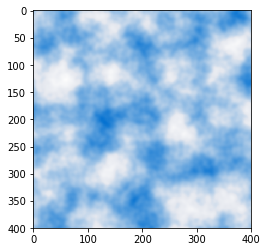

In [72]:
# Generate "sky" using multiple layers with different node distances
img0 = generate_2D_perlin_noise(400, 80)
img1 = generate_2D_perlin_noise(400, 40)
img2 = generate_2D_perlin_noise(400, 20)
img3 = generate_2D_perlin_noise(400, 10)

img = (img0 + img1 + img2 + img3) / 4
cmap = LinearSegmentedColormap.from_list('sky',
                                        [(0, '#0572D1'),
                                         (0.75, '#E5E8EF'),
                                         (1, '#FCFCFC')])
img = cm.ScalarMappable(cmap=cmap).to_rgba(img)
plt.imshow(img)

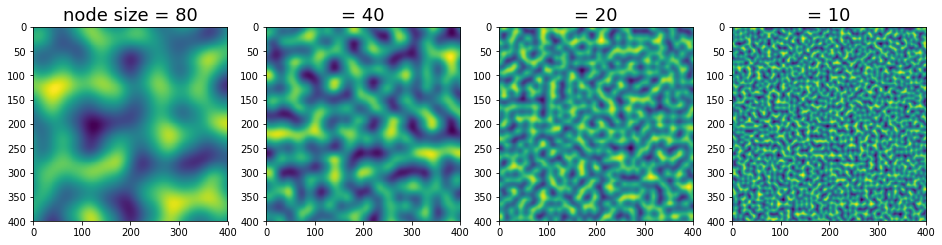

In [73]:
# Testing parameters of the noise generator

plt.figure(figsize=(16,16))
columns = 4
images = [img0, img1, img2, img3]
# images = [img0<0.8, img1<0.8, img2<0.8, img3<0.8]
titles = ['node size = 80', '= 40', '= 20', '= 10']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

We can make a more realistic binary cloud mask by adding together multiple images generated with different node distances, and then thresholding the summed image. Thresholding by percentiles also conveniently gives us a range of different cloud covers that can be used to create the accuracy curve of the model.

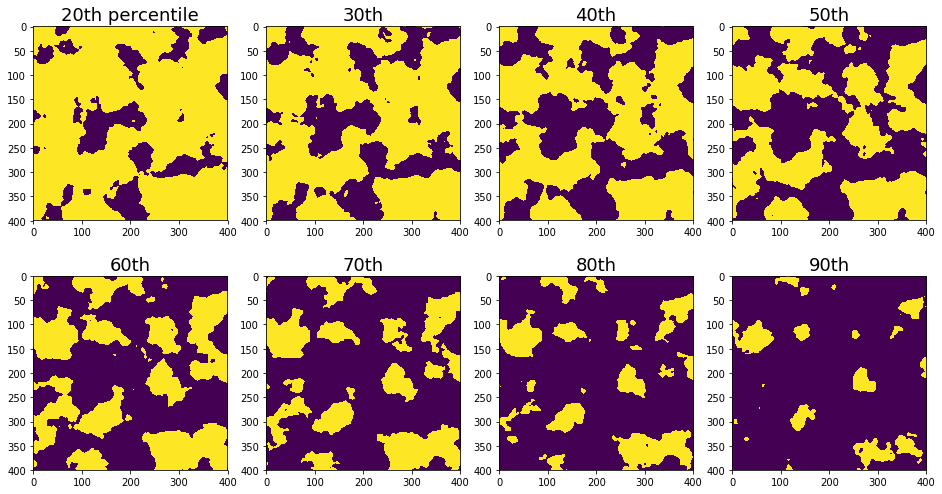

In [74]:
img_sum = np.sum(img, axis=2)

plt.figure(figsize=(16,13))
columns = 4
images = [img_sum>np.percentile(img_sum, 20),
          img_sum>np.percentile(img_sum, 30),
         img_sum>np.percentile(img_sum, 40),
          img_sum>np.percentile(img_sum, 50),
         img_sum>np.percentile(img_sum, 60),
          img_sum>np.percentile(img_sum, 70),
         img_sum>np.percentile(img_sum, 80),
         img_sum>np.percentile(img_sum, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

### Problem:
The code above only creates a square NxN matrix, whereas Landsat images are not square. We need NxM matrix. 

## 2-dimensional *non-square* Perlin noise generation
From https://github.com/caseman/noise

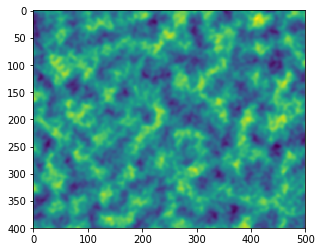

In [75]:
import sys
from noise import pnoise2, snoise2
from math import sqrt

myImg = np.zeros((400,500))
octaves = 3
freq = np.ceil(sqrt(450)) * octaves
for y in range(500):
    for x in range(400):
          myImg[x,y] = snoise2(x/freq, y/freq, octaves)      
plt.imshow(myImg)

## Cloud generation to mask Landsat imagery

Now let's generate Perlin noise large enough to cover an actual Landsat image

In [76]:
import rasterio
path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/'
with rasterio.open(path+'stack/stack.tif') as ds:
    shape = ds.shape
    print(shape)

(3501, 4322)


Cloud generation time for (3501, 4322) size image: 00:00:25.57


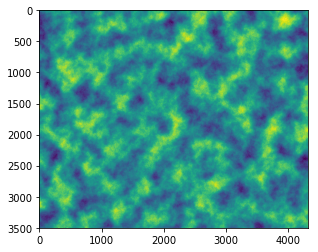

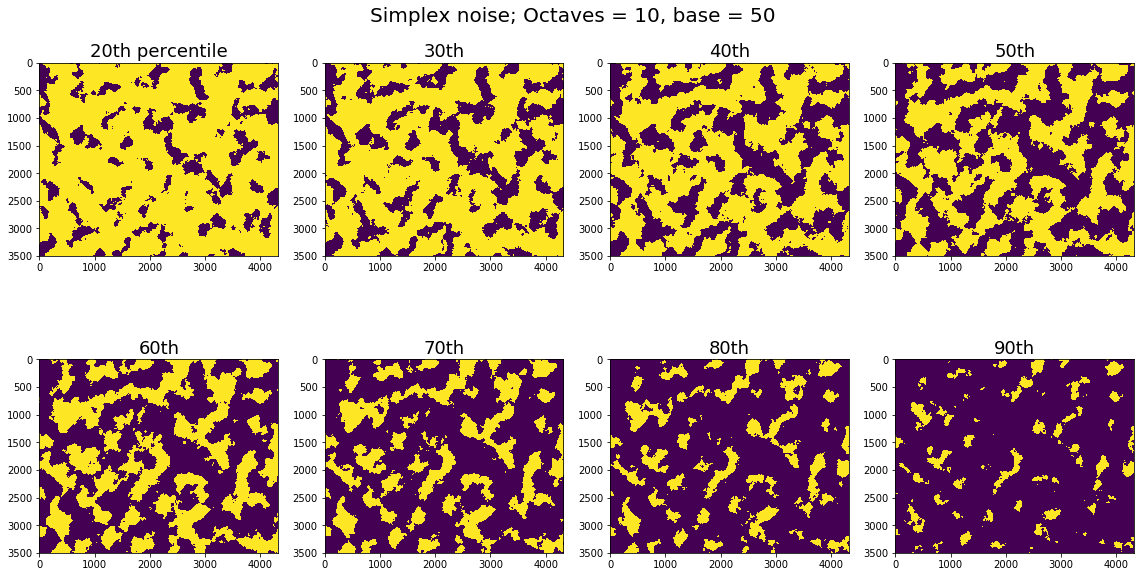

In [77]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = snoise2(x/freq, y/freq, octaves)      
            
plt.imshow(cloudMask)

print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

plt.figure(figsize=(16,13))
columns = 4
images = [cloudMask>np.percentile(cloudMask, 20),
          cloudMask>np.percentile(cloudMask, 30),
         cloudMask>np.percentile(cloudMask, 40),
          cloudMask>np.percentile(cloudMask, 50),
         cloudMask>np.percentile(cloudMask, 60),
          cloudMask>np.percentile(cloudMask, 70),
         cloudMask>np.percentile(cloudMask, 80),
         cloudMask>np.percentile(cloudMask, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
    plt.suptitle('Simplex noise; Octaves = 10, base = 50', fontsize=20)
    plt.tight_layout()

Cloud generation time for (3501, 4322) size image: 00:00:25.45


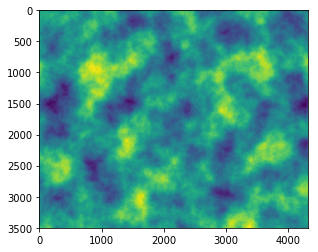

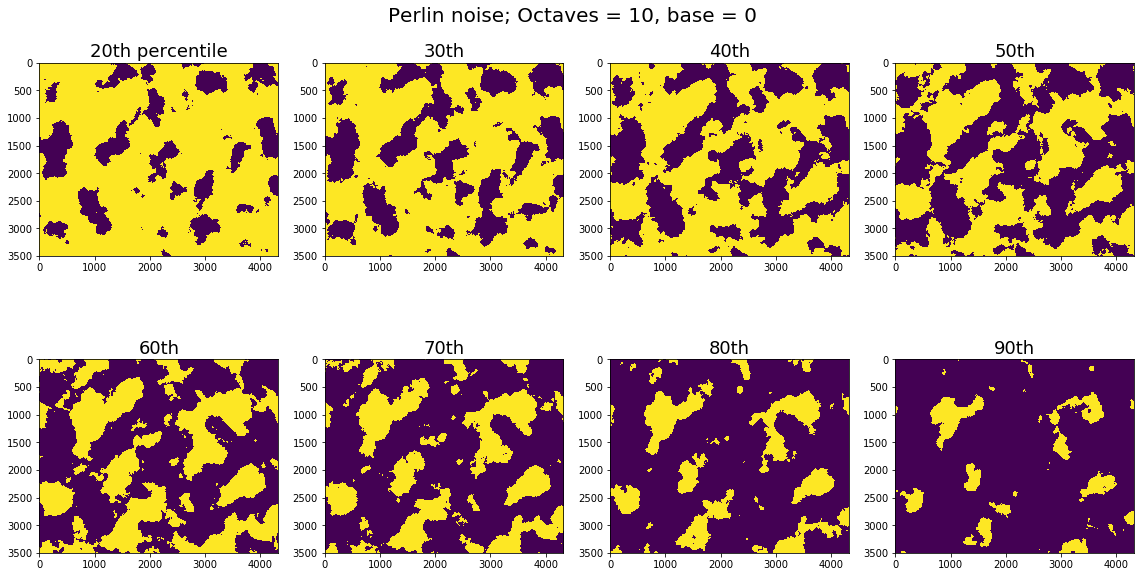

In [78]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = pnoise2(x/freq, y/freq, octaves)      
            
plt.imshow(cloudMask)

print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

plt.figure(figsize=(16,13))
columns = 4
images = [cloudMask>np.percentile(cloudMask, 20),
          cloudMask>np.percentile(cloudMask, 30),
         cloudMask>np.percentile(cloudMask, 40),
          cloudMask>np.percentile(cloudMask, 50),
         cloudMask>np.percentile(cloudMask, 60),
          cloudMask>np.percentile(cloudMask, 70),
         cloudMask>np.percentile(cloudMask, 80),
         cloudMask>np.percentile(cloudMask, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
    plt.suptitle('Perlin noise; Octaves = 10, base = 0', fontsize=20)
    plt.tight_layout()

Cloud generation time for (3501, 4322) size image: 00:00:51.32


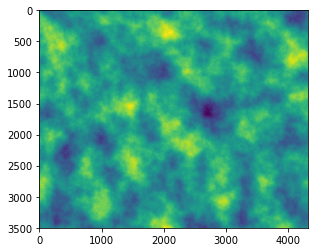

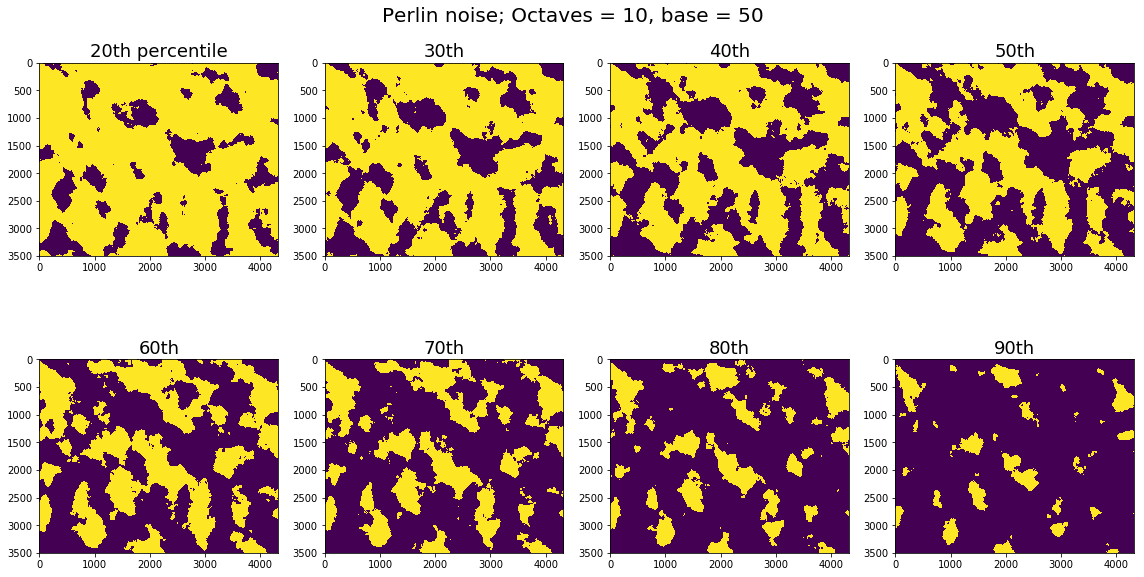

In [79]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = pnoise2(x/freq, y/freq, octaves, base=50)      
            
plt.imshow(cloudMask)

print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

plt.figure(figsize=(16,13))
columns = 4
images = [cloudMask>np.percentile(cloudMask, 20),
          cloudMask>np.percentile(cloudMask, 30),
         cloudMask>np.percentile(cloudMask, 40),
          cloudMask>np.percentile(cloudMask, 50),
         cloudMask>np.percentile(cloudMask, 60),
          cloudMask>np.percentile(cloudMask, 70),
         cloudMask>np.percentile(cloudMask, 80),
         cloudMask>np.percentile(cloudMask, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
    plt.suptitle('Perlin noise; Octaves = 10, base = 50', fontsize=20)
    plt.tight_layout()

Using 'base' parameter as a random seed parameter.

Cloud generation time for (3501, 4322) size image: 00:00:44.17


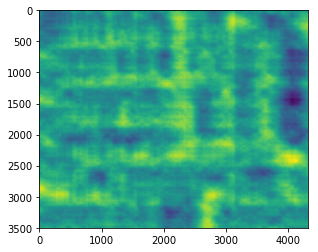

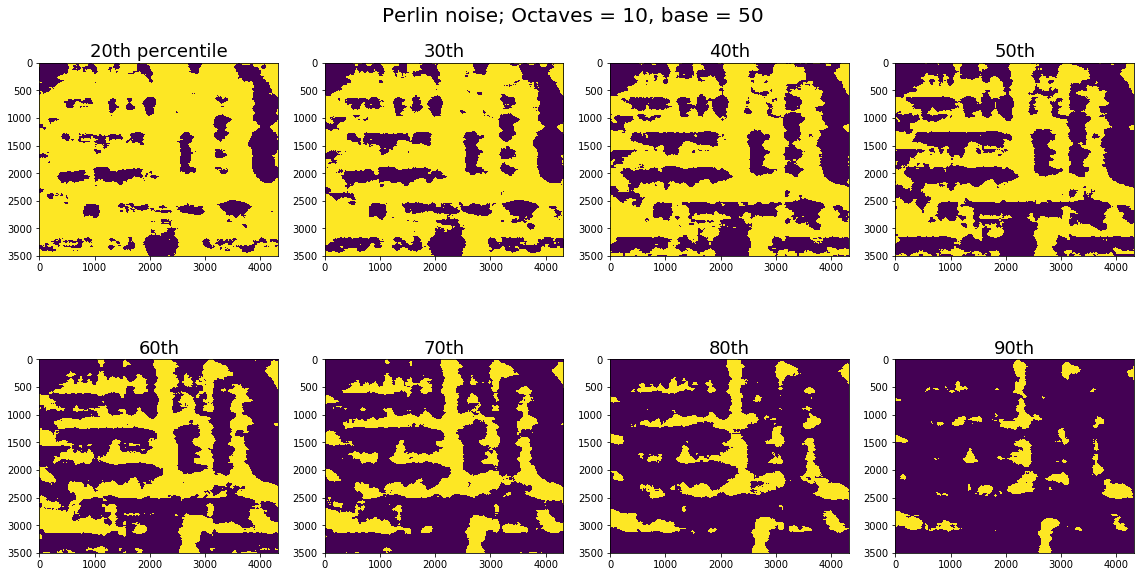

In [80]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = pnoise2(x/freq, y/freq, octaves, base=1000)      
            
plt.imshow(cloudMask)

print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

plt.figure(figsize=(16,13))
columns = 4
images = [cloudMask>np.percentile(cloudMask, 20),
          cloudMask>np.percentile(cloudMask, 30),
         cloudMask>np.percentile(cloudMask, 40),
          cloudMask>np.percentile(cloudMask, 50),
         cloudMask>np.percentile(cloudMask, 60),
          cloudMask>np.percentile(cloudMask, 70),
         cloudMask>np.percentile(cloudMask, 80),
         cloudMask>np.percentile(cloudMask, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
    plt.suptitle('Perlin noise; Octaves = 10, base = 50', fontsize=20)
    plt.tight_layout()

### Using a high base as a seed parameter can lead to some weird looking clouds
So instead we can use this suggestion (https://github.com/caseman/noise/issues/4) and use 3D noise with a constant scalar for the z dimension. However, the random seeds for different images will need to be quite different to yield really unique cloudmasks, because similar seed values yield similar results.

Cloud generation time for (3501, 4322) size image: 00:00:39.75


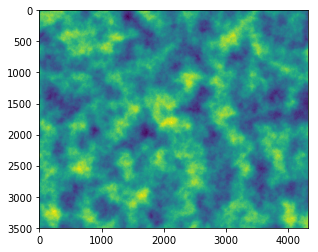

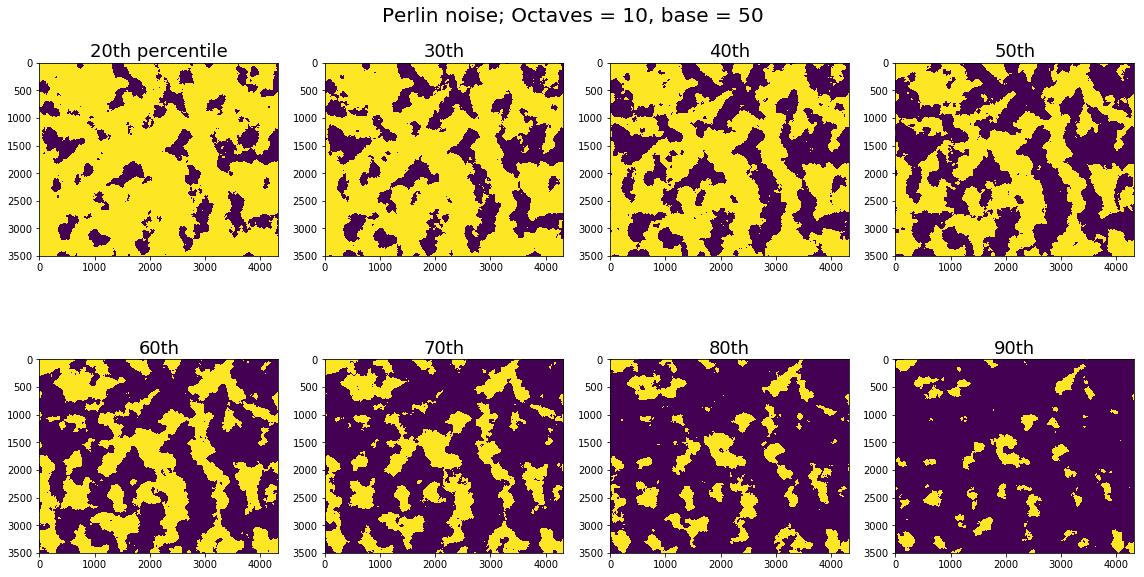

In [82]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
seed = 1500
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = snoise3(x/freq, y/freq, seed, octaves)      
            
plt.imshow(cloudMask)

print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

plt.figure(figsize=(16,13))
columns = 4
images = [cloudMask>np.percentile(cloudMask, 20),
          cloudMask>np.percentile(cloudMask, 30),
         cloudMask>np.percentile(cloudMask, 40),
          cloudMask>np.percentile(cloudMask, 50),
         cloudMask>np.percentile(cloudMask, 60),
          cloudMask>np.percentile(cloudMask, 70),
         cloudMask>np.percentile(cloudMask, 80),
         cloudMask>np.percentile(cloudMask, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
    plt.suptitle('Perlin noise; Octaves = 10, base = 50', fontsize=20)
    plt.tight_layout()

### Notes:
 - Octaves = 10, with persistence = 0.5 and lacunarity = 2.0 (defaults), are good settings. There isn't a seed parameter, but the base parameter can be changed to generate different clouds with the same settings.

----------------------------

# Generating cloud masks

In [83]:
import os

path = 'C:/Users/ipdavies/CPR/data'

# Get list of all images
img_list = []
for file in os.listdir(path+'/images'):
        img_list.append(file)

# Make directory for cloudmasks if none exists
try:
    os.mkdir(path + '/cloudmasks')
except FileExistsError:
    print('Cloudmask directory already exists')
    
# Get list of existing cloudmasks and subtract these existing images w/ cloudmasks from our list of files
for mask in os.listdir(path+'/cloudmasks'):
    img_list.remove(mask)

print(img_list)

Cloudmask directory already exists
['4101_LC08_027038_20131103', '4101_LC08_027038_20131103_2', '4101_LC08_027039_20131103', '4115_LC08_021033_20131227_2', '4337_LC08_026038_20160325_1']


In [136]:
img_list = ['4337_LC08_026038_20160325_1']
path = 'C:/Users/ipdavies/CPR/data'

In [137]:
# Get random seeds. Want a different seed for each unique image so the cloudmasks are not identical
import random
import rasterio

seeds = []
for x in range(len(img_list)):
    seeds.append(random.randint(1,10000))

pctls = [10, 20, 30, 40, 50, 60, 70, 80, 90]

octaves = 10

for num, img in enumerate(img_list):
    
    # Get shape of image to be masked
    with rasterio.open(path+'/images/'+img+'/stack/stack.tif') as ds:
        shape = ds.shape
    
    clouds = np.zeros(shape)
    freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
    
    # Generate 2D (technically 3D, but uses a scalar for z) simplex noise
    for y in range(shape[1]):
        for x in range(shape[0]):
              clouds[x,y] = snoise3(x/freq, y/freq, seeds[num], octaves)
    
    # Make directory for cloudmasks if none exists
    try:
        os.mkdir(path + '/cloudmasks/' + img)
    except FileExistsError:
        print('Cloudmask directory '+img+ ' already exists')
    
    # Create binary cloudmasks by thresholding into cloud cover percentiles
    # Then saves as numpy binary  file
    for i, pctl in enumerate(pctls):
        cloudMask = clouds > np.percentile(clouds, pctls[i])
        filename = path+'/cloudmasks/'+img+'/'+img+'_clouds_'+str(pctl)
        np.save(filename, cloudMask)


Cloudmask directory 4337_LC08_026038_20160325_1 already exists


In [121]:
path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/4337_LC08_026038_20160325_1.zip'

# Stack exported tifs from GEE into one multiband tif
import rasterio
import os
from zipfile import *
import pandas as pd

file_list = []
with ZipFile(path, 'r') as f:
    names = f.namelist()
    names = ['zip://'+path+'!'+name for name in names]
    for file in names:
        if file.endswith('.tif'):
            file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path + '/../'+'/stack')
except FileExistsError:
    print('Stack directory already exists')

# Remove stack file if already exists
try:
    os.remove(path + '/../' + '/stack/stack.tif')
    print('Removing existing "stack.tif" and creating new one')
except FileNotFoundError:
#     pass
    print('Creating "stack.tif"')

with rasterio.open(path + '/../' + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


Stack directory already exists
Creating "stack.tif"


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


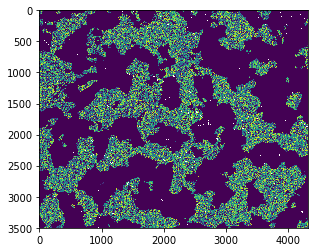

In [132]:
# plt.imshow(images[4])
path = 'C:/Users/ipdavies/CPR/data'
with rasterio.open(path+'/images/'+img+'/stack/stack.tif') as ds:
    ds = ds.read()
    ds[ds == -999999] = np.nan
    myMask = images[4]
    maskedImg = ds * myMask
    plt.imshow(maskedImg[0])

